In [307]:
import rasterio as rst
import rasterio.mask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box
from copy import deepcopy
import shapely

%matplotlib inline

# Get caravans and raster data

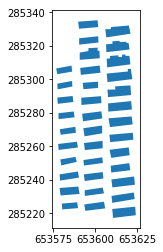

In [2]:
# read in caravans geometries
caravans = gpd.read_file('./Data/caravans.shp')
caravans.plot()

In [210]:
# read tile
tile = rst.open('./Data/Ortho_RGBN_P00081520_20160506_20160923_20cm_res.tif')

In [4]:
# get xmin and ymin of image tile
tile_xmin, tile_ymax, cellsize = (tile.bounds.left, tile.bounds.top, tile.res[0])

In [5]:
# get image array
image = tile.read()

In [6]:
# move axis and drop infrared channel
image = np.moveaxis(image,0,-1)[:,:,0:3]

(4000, 3000)

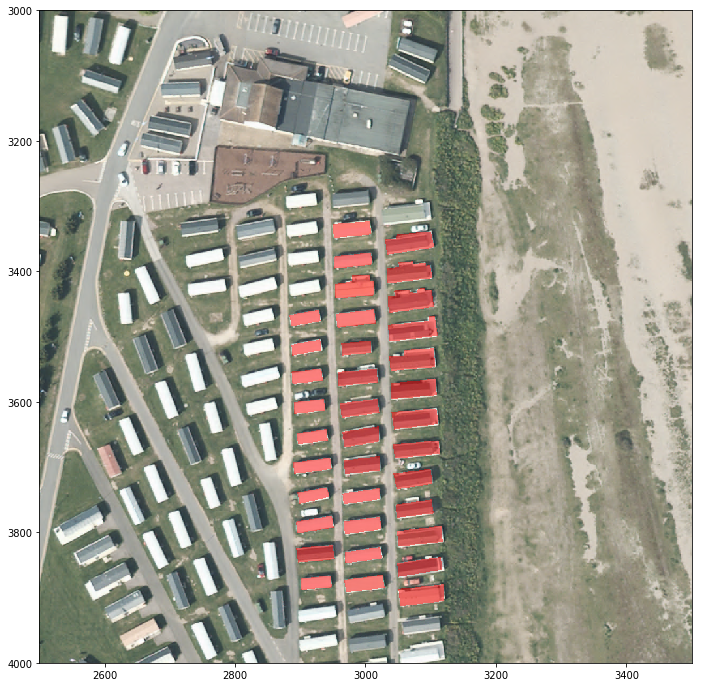

In [7]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
caravan_mask = mask.raster_geometry_mask(tile, caravans['geometry'], invert=True)[0]
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# zoom to area that holds caravan masks
ax.set_xlim([2500,3500])
ax.set_ylim([4000,3000])

# Plot centroids of caravans in image coords

In [8]:
def getImageCoords(geom, xmin, ymax, cellsize):
    c_x, c_y = np.array(geom.centroid)
    img_x = (c_x - xmin) / cellsize
    img_y = (ymax - c_y) / cellsize
    return Point(img_x, img_y)

In [9]:
centroids = caravans['geometry'].apply(lambda x: getImageCoords(x, tile_xmin, tile_ymax, cellsize))

(4000, 3000)

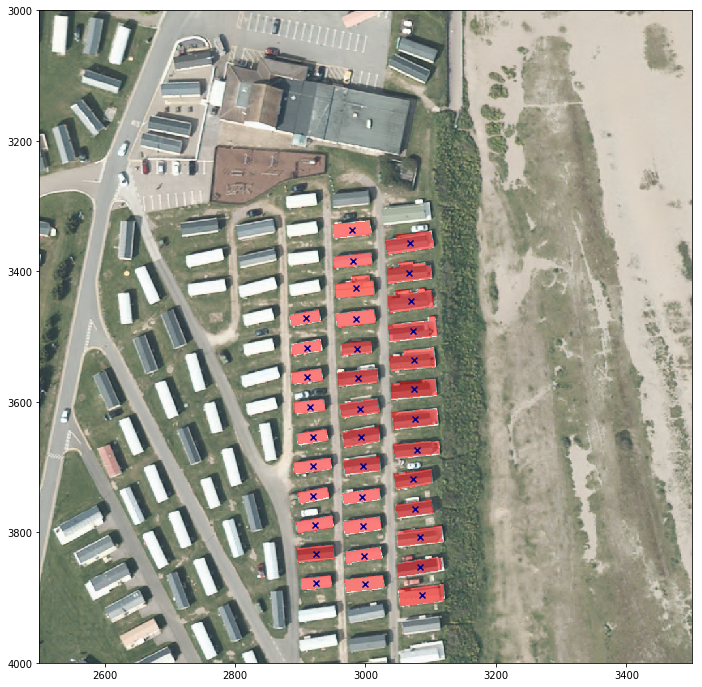

In [10]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
caravan_mask = mask.raster_geometry_mask(tile, caravans['geometry'], invert=True)[0]
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# plot centroids
centroids.plot(color = 'darkblue', marker = 'x', ax=ax)

# zoom to area that holds caravan masks
ax.set_xlim([2500,3500])
ax.set_ylim([4000,3000])

# Create boxes

In [11]:
def getImageBox(geom, xmin, ymax, cellsize):
    c_x, c_y = np.array(geom.centroid)
    img_x = ((c_x - xmin) // cellsize) - 112
    img_y = ((ymax - c_y) // cellsize) - 112
    return box(img_x, img_y, img_x + 224, img_y + 224)

In [76]:
# create a variable with the boxes.
boxes = caravans['geometry'].apply(lambda x: getImageBox(x, tile_xmin, tile_ymax, cellsize))

(4000, 3000)

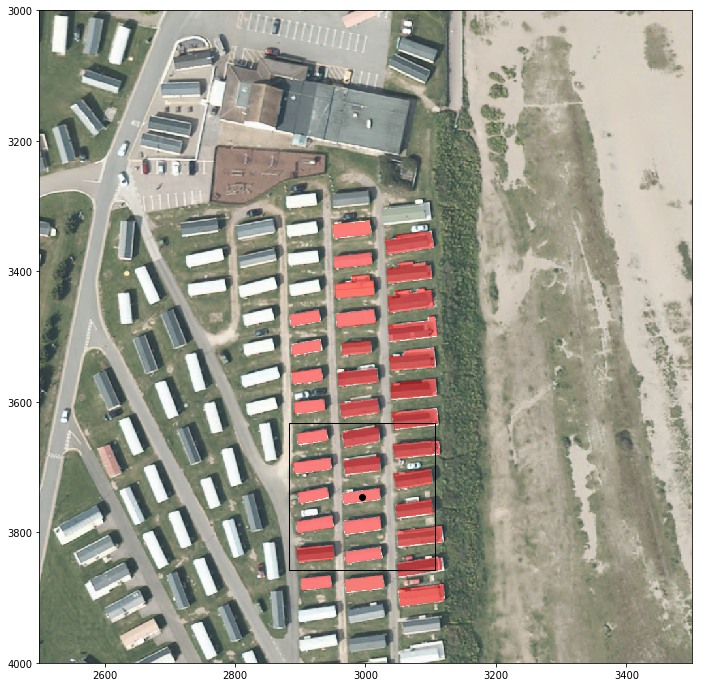

In [13]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
caravan_mask = mask.raster_geometry_mask(tile, caravans['geometry'], invert=True)[0]
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# plot example centroid and box
centroids[0:1].plot(color = 'k', ax=ax)
boxes[0:1].plot(facecolor = 'none', edgecolor = 'k', ax=ax)

# zoom to area that holds caravan masks
ax.set_xlim([2500,3500])
ax.set_ylim([4000,3000])

# Get image subsets

In [219]:
def georeferenceBox(tile, xmin, ymin):
    trans = deepcopy(tile.get_transform())
    trans[0] = trans[0] + (xmin * trans[1])
    trans[3] = trans[3] + ((ymin) * trans[5])
    return rst.Affine.from_gdal(*trans)

In [218]:
def subSetImage(image, boxes, georef = False, tile = None):
    xmin, ymin, xmax, ymax = map(int, boxes.bounds)
    if georef:
        if not tile:
            print("Please supply the original image tile")
        else:
            new_transform = georeferenceBox(tile, xmin, ymin)
            return image[ymin:ymax,xmin:xmax,:], new_transform
    else:
        return image[ymin:ymax,xmin:xmax,:]

In [20]:
subsets = []
for b in boxes.sample(9):
    subsets.append(subSetImage(image, b))

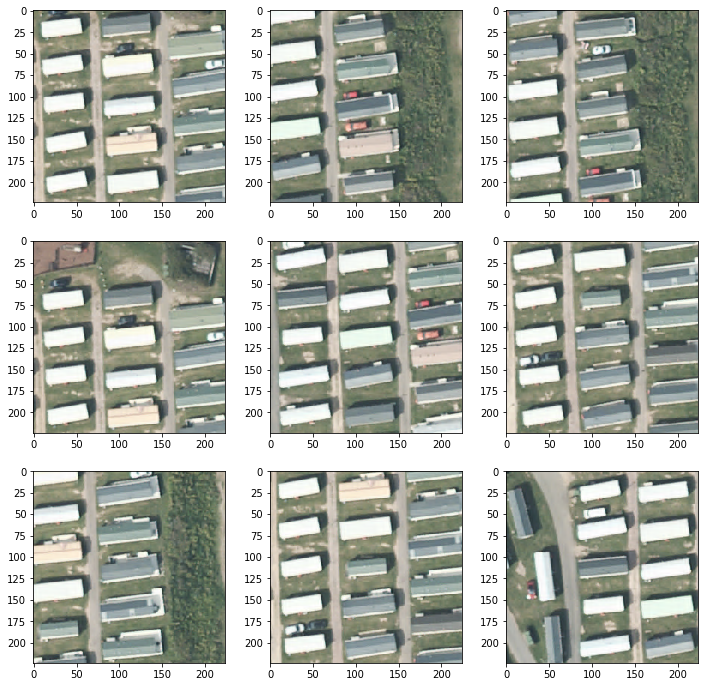

In [21]:
f, axes = plt.subplots(3,3,figsize = (12,12))
# plot images
i = 0
for row in axes:
    for ax in row:
        ax.imshow(subsets[i])
        i+=1

# Make Image Masks

In [220]:
sub, trans = subSetImage(image, boxes[0], True, tile)
save = './Data/sub0.tif'

with rst.open(save, 'w', driver= 'GTiff', compress = 'lzw',
              width = sub.shape[0], height = sub.shape[1], count = sub.shape[2],
              transform = trans, dtype= 'uint8' ) as out:
    out.write(np.moveaxis(sub,-1,0))

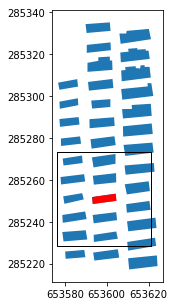

In [233]:
with rst.open(save,'r') as test:
    boxx = gpd.GeoSeries(box(test.bounds.left, test.bounds.bottom, test.bounds.right, test.bounds.top))
    f, ax = plt.subplots(figsize=(5,5))

    caravans.plot(ax=ax)
    caravans[0:1].plot(color='r', ax=ax)
    boxx.plot(facecolor = 'none', edgecolor = 'k', ax=ax)

# Subset Mask

In [282]:
with rst.open(save,'r') as subset:
    print(subset.bounds)
    caravan_mask = mask.raster_geometry_mask(subset, caravans['geometry'], invert=True)[0].astype(int)

BoundingBox(left=653576.4, bottom=285228.60000000003, right=653621.2000000001, top=285273.4)


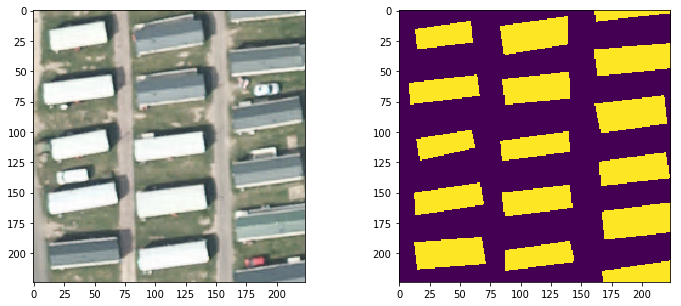

In [271]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.imshow(sub)
ax2.imshow(caravan_mask)

# Subset bounding boxes

In [318]:
def getImageBox(geom, xmin, ymax, cellsize):
    new_xmin = (geom.bounds[0] - xmin) // cellsize
    new_ymin = (ymax - geom.bounds[1]) // cellsize
    new_xmax = (geom.bounds[2] - xmin) // cellsize
    new_ymax = (ymax - geom.bounds[3]) // cellsize
    return box(new_xmin, new_ymin, new_xmax, new_ymax)
    
def getBBs(geom, tile_string):
    envelopes = geom.envelope
    with rst.open(tile_string,'r') as tile:
        xmin = tile.bounds.left
        xmax = tile.bounds.right
        ymin = tile.bounds.bottom
        ymax = tile.bounds.top
        cellsize = tile.res[0]
        tile_box = box(xmin, ymin, xmax, ymax)
    
    envelopes = envelopes[envelopes.within(tile_box)]
    
    return envelopes.apply(lambda x: getImageBox(x, xmin, ymax,cellsize))

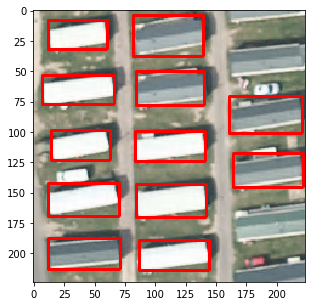

In [324]:
f, ax = plt.subplots(figsize = (5,5))

ax.imshow(sub)
getBBs(caravans,save).plot(facecolor = 'none', edgecolor = 'r', lw = 3, ax=ax)